<a href="https://colab.research.google.com/github/PaoloBarba/ADM_HM1_Barba_1885324/blob/main/detr_object_detection_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tuning DETR on a custom dataset for object detection

In this notebook, we are going to fine-tune [DETR](https://huggingface.co/docs/transformers/model_doc/detr) (end-to-end object detection with Transformers) on a custom object detection dataset. The goal for the model is to detect garbages in pictures.

* Original DETR paper: https://arxiv.org/abs/2005.12872
* Original DETR repo: https://github.com/facebookresearch/detr

### Note regarding GPU memory

`DetrImageProcessor` by default resizes each image to have a `min_size` of 800 pixels and a `max_size` of 1333 pixels (as these are the default values that DETR uses at *inference* time). Note that this can stress-test the memory of your GPU when *training* the model, as the images are flattened after sent through the convolutional backbone. The sequence length that is sent through the Transformer is typically of length (height*width/32^2). So if you consider an image of size (900, 900) for example, the sequence length is 900^2/32^2 = 791, which is larger than what NLP models like BERT use (512). It's advised to use a batch size of 2 on a single GPU. You can of course also initialize `DetrImageProcessor` with a smaller `size` and/or `max_size` to use bigger batches.


### Note regarding data augmentation

DETR actually uses several image augmentations during training. One of them is **scale augmentation**: they set the `min_size` randomly to be one of [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800] as can be seen [here](https://github.com/facebookresearch/detr/blob/a54b77800eb8e64e3ad0d8237789fcbf2f8350c5/datasets/coco.py#L122). However, we are not going to add any of the augmentations that are used in the original implementation during training. It works fine without them.

### Training framework

We're going to fine-tune the model using [PyTorch Lightning](https://lightning.ai/pages/open-source/), but of course you could also train the model using native PyTorch, the 🤗 [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class, 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index), or any other framework you prefer.

Also big thanks to the creator of [this notebook](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb), which helped me a lot in understanding how to fine-tune DETR on a custom dataset.


## Install Requirements

As a first step, we will download the `requirements.txt` file from the github repo and install all the needed packages.

In [ ]:
!wget -O requirements.txt https://raw.githubusercontent.com/aml-2023/final-project/detr/requirements.txt
!pip install -q -r requirements.txt

--2023-12-13 16:16:58--  https://raw.githubusercontent.com/aml-2023/final-project/detr/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     108  --.-KB/s    in 0s      

2023-12-13 16:16:58 (1.19 MB/s) - ‘requirements.txt’ saved [108/108]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Fetch Data
The garbage dataset comes in the COCO format, which the `DetrImageProcessor` class can use directly. First, we download the `fetch_data.sh` script from the github repo and then after running it, we will have all of the data inside a `data/` folder.

In [1]:
!wget -O fetch_data.sh https://raw.githubusercontent.com/aml-2023/final-project/detr/fetch_data.sh
!bash fetch_data.sh

--2023-12-13 21:04:01--  https://raw.githubusercontent.com/aml-2023/final-project/detr/fetch_data.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531 [text/plain]
Saving to: ‘fetch_data.sh’

fetch_data.sh       100%[===================>]     531  --.-KB/s    in 0s      

2023-12-13 21:04:01 (36.9 MB/s) - ‘fetch_data.sh’ saved [531/531]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   885  100   885    0     0   2928      0 --:--:-- --:--:-- --:--:--  2930
100  274M  100  274M    0     0   108M      0  0:00:02  0:00:02 --:--:--  138M
Archive:  roboflow.zip
 extracting: data/README.dataset.txt  
 extracting: data/README.roboflow.txt  
   creat

## Create PyTorch dataset + dataloaders

The standard way in PyTorch to train a model is by creating datasets and a corresponding dataloaders. See [this guide](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) if you're not familiar with them.

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add an image processor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [2]:
import torchvision
import torch
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Based on the class defined above, we create training, validation, and test datasets.

---



In [4]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='data/train', processor=processor)
val_dataset = CocoDetection(img_folder='data/valid', processor=processor, train=False)
test_dataset = CocoDetection(img_folder='data/test', processor=processor, train=False)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


As you can see, this dataset is tiny:

In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 3027
Number of validation examples: 306
Number of test examples: 201


Let's verify an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`.

Image n°2829


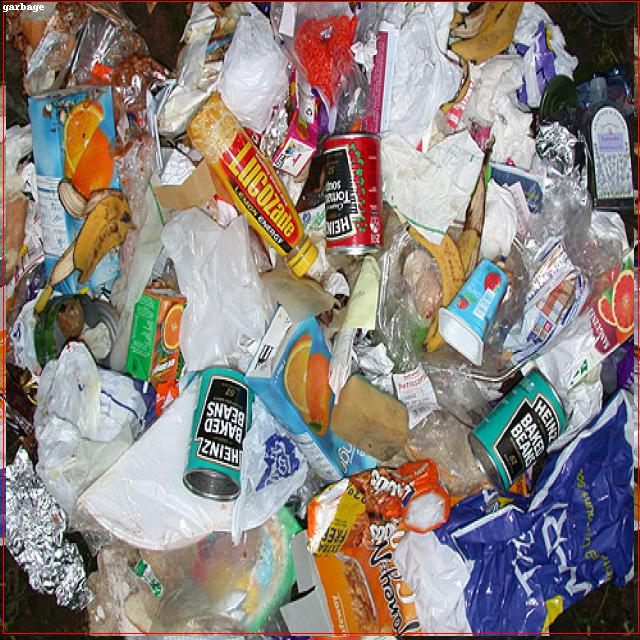

In [6]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('data/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

Next, let's create corresponding PyTorch dataloaders, which allow us to get batches of data. We define a custom `collate_fn` to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (`pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1)/which are padding (0).  

In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

## Subsetting the Data
We don't need to fine tune the model on all of the data, it is enough to just take a small part of it. This also helps with speeding up the training immensely.

As a start, we take only 10% of images.

In [8]:
train_subset_size = int(0.1 * len(train_dataset))

# randomly sample 10% of indeces
train_subset_idx = np.random.randint(low=0, high=len(train_dataset), size=(train_subset_size))
trainset_subset = torch.utils.data.Subset(train_dataset, train_subset_idx)
train_subset_loader = DataLoader(trainset_subset, collate_fn=collate_fn, batch_size=4, shuffle=True)
batch = next(iter(train_subset_loader))

In [9]:
val_subset_size = int(0.1 * len(val_dataset))

# randomly sample 10% of indeces
val_subset_idx = np.random.randint(low=0, high=len(val_dataset), size=(val_subset_size))
val_subset = torch.utils.data.Subset(val_dataset, val_subset_idx)
val_subset_loader = DataLoader(val_subset, collate_fn=collate_fn, batch_size=2)

In [10]:
test_subset_size = int(0.1 * len(test_dataset))

# randomly sample 10% of indeces
test_subset_idx = np.random.randint(low=0, high=len(test_dataset), size=(test_subset_size))
test_subset = torch.utils.data.Subset(test_dataset, test_subset_idx)
test_subset_loader = DataLoader(test_subset, collate_fn=collate_fn, batch_size=2)

Let's verify the keys of a single batch:

Let's verify the shape of the `pixel_values`, and check the `target`::

In [14]:
pixel_values, target = train_dataset[0]

## Train the model using PyTorch Lightning

Here we define a `LightningModule`, which is an `nn.Module` with some extra functionality.

For more information regarding PyTorch Lightning, I recommend the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.35105442.2002381006.1623231889-1738348008.1615553774) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/lightning-tutorials/tree/aeae8085b48339e9bd9ab61d81cc0dc8b0d48f9c/.notebooks/starters).

You can of course just train the model in native PyTorch as an alternative.

In [ ]:
!pip install 'pytorch_lightning'

In [16]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_subset_loader

     def val_dataloader(self):
        return val_subset_loader

As PyTorch Lightning by default logs to Tensorboard, let's start it:

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Here we define the model, and verify the outputs.

In [17]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The logits are of shape `(batch_size, num_queries, number of classes + 1)`. We model internally adds an additional "no object class", which explains why we have one additional output for the class dimension.

# Train
Next, let's train! We train for 50 epochs, and also use gradient clipping. You can refresh Tensorboard above to check **the** various losses.

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(devices=1, max_epochs=50, gradient_clip_val=0.1)
trainer.fit(model)

# Or Load a Model

In [ ]:
# load DETR trained for 50 epochs
!wget -O model_detr_50_epochs.pt https://aml-2023.s3.eu-north-1.amazonaws.com/final-project/model_detr_50_epochs.pt

model.load_state_dict(torch.load("model_detr_50_epochs.pt", map_location=device))

## Evaluate the model

The evaluation code below is written by the balloon guy, I think we can just write our own to avoid having to rely on his code for that.

Finally, we evaluate the model on the validation set. For this we make use of the `CocoEvaluator` class available in a [tiny PyPi package](https://github.com/NielsRogge/coco-eval) I made. This class is entirely based on the original evaluator class used by the DETR authors.

To run the evaluation, we must make sure that the outputs of the model are in the format that the metric expects. For that we need to turn the boxes which are in (x1, y1, x2, y2) format into (x, y, width, height), and turn the predictions into a list of dictionaries:

In [19]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

# OUR EVALUATION
Our evaluation should do something like this, loop over the dataloader, prepare the inputs to the model, and then we need to get the metrics we are interested in.

* MAP
* GIoU
* L1 Bbox error

In [20]:
pip install pycocotools

In [ ]:
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
#from coco_eval import CocoEvaluator
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming you have already loaded your fine-tuned model, val_dataloader, and COCO annotations
# Make sure to install pycocotools using: pip install pycocotools

model.to(device)
model.eval()

coco_gt = COCO("data/test/_annotations.coco.json" )  # Load COCO annotations for the validation set
evaluator = CocoEvaluator(coco_gt = coco_gt, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(test_dataloader , colour = "blue") ):
    if idx == 84:
      continue

    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()


In [27]:
YOLO_test_metrics = { 'AP50': 0.6636801269588519 ,
                     'AP75': 0.28750733430798714 ,
                     'AP50_95': 0.31425620574013063
                     }

DETR_test_metrics = { 'AP50': 0.767,
                     'AP75': 0.351,
                      'AP50_95': 0.401}


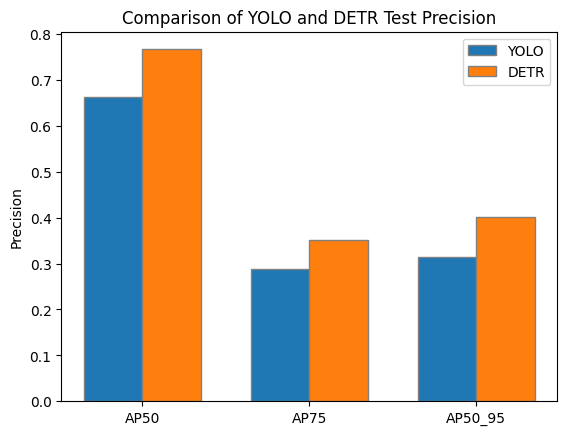

In [28]:
# Extracting metric names and values
metric_names = list(YOLO_test_metrics.keys())
YOLO_values = list(YOLO_test_metrics.values())
DETR_values = list(DETR_test_metrics.values())

# Bar width
bar_width = 0.35

# Bar positions
r1 = range(len(metric_names))
r2 = [x + bar_width for x in r1]

# Creating the bar chart
plt.bar(r1, YOLO_values, width=bar_width, edgecolor='grey', label='YOLO')
plt.bar(r2, DETR_values, width=bar_width, edgecolor='grey', label='DETR')

# Adding labels and title
plt.xlabel('')
plt.ylabel('Precision')
plt.title('Comparison of YOLO and DETR Test Precision')
plt.xticks([r + bar_width/2 for r in range(len(metric_names))], metric_names)

# Adding legend
plt.legend()

# Display the plot
plt.show()


## Comment on the metric

First of all we have to define what we mean with **TP** (True Positive) **FN** (False Negative) , **FP** (False Postive) and **TN** (True Negative) in the context of object detection.

We do identify the TP by counting the number of predicted bounding box that have a sufficient overlap (IoU) with the ground truth bounding boxes.

We do identify the FN by counting the number of ground truth bounding boxes that do not have a corresponding predicted bounding box with sufficient overlap.

We do identify FP by counting the predicted bounding boxes that do not have a sufficient overlap with any ground truth bounding box

We do not identify TN due to the imbalance between positive and negative predictions.his is because the space of possible locations for objects is typically much larger than the space occupied by actual objects.


Then the formula to compute the precision and recall will be:

$$Precision = \frac{TP}{TP + FP}$$

$$Recall = \frac{TP}{TP + FN} $$

It is trivial that the precision and recall will depend on the IoU threshold.

### Considering IoU threshold = $0.5$

In this case we consider TP when the IoU between gt bounding box and the predicted one is greater than $0.5$. This is the easiest detection scenario.
Our model reach out a $0.748$ precision score; meaning that of all the positive predictions we have, almost $75\%$ of them have a IoU greater than $0.5$

### Considering IoU threshold = $0.75$

Considering this scenario (more hard detection), the precision that our model reach out is: $0.398$. Meaing that almost $40\%$ of the positive predictions  have a predicted bounding box that overlaps with the ground truth one with an intersection over union metric greater than $0.75$.


### Considering IoU threshold  moving from 0.5. to 0.95

In this scenario we do not set a fixed trehshold but we let vary the IoU threshold from $0.5$ to $0.95$ with steps of $0.05$. The precision metric is computed by averaging all the precision obtained at different threshold. In this case the model is able to reach  $0.404$ as the precision metric.

In this scenario we reach out a Recall around $0.5$, meaning that succesfully detect around $50\%$ of the ground truth bounding boxes


[Note: The MaxDets parameter refers to the maximum number of detections per image that will be considered while computing the metric]




## Inference (+ visualization)

Let's visualize the predictions of DETR on the first image of the validation set.

In [189]:
from PIL import Image
from torchvision import transforms

# Load and preprocess your image
image_path = '/content/Garbage_1.jpeg'
img = Image.open(image_path)

transform = transforms.Compose([
    transforms.ToTensor(),
])

input_image = transform(img)

In [190]:
pixel_values = input_image.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 1500, 2000])


In [191]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [192]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        #text = f'{model.config.id2label[label]}: {score:0.2f}'
        #ax.text(xmin, ymin, text, fontsize=15,
                #bbox=dict(facecolor='yellow', alpha=0.5))
    output_file = 'Garbage_1.svg'
    plt.savefig(output_file, format='svg')
    plt.axis('off')
    plt.show()

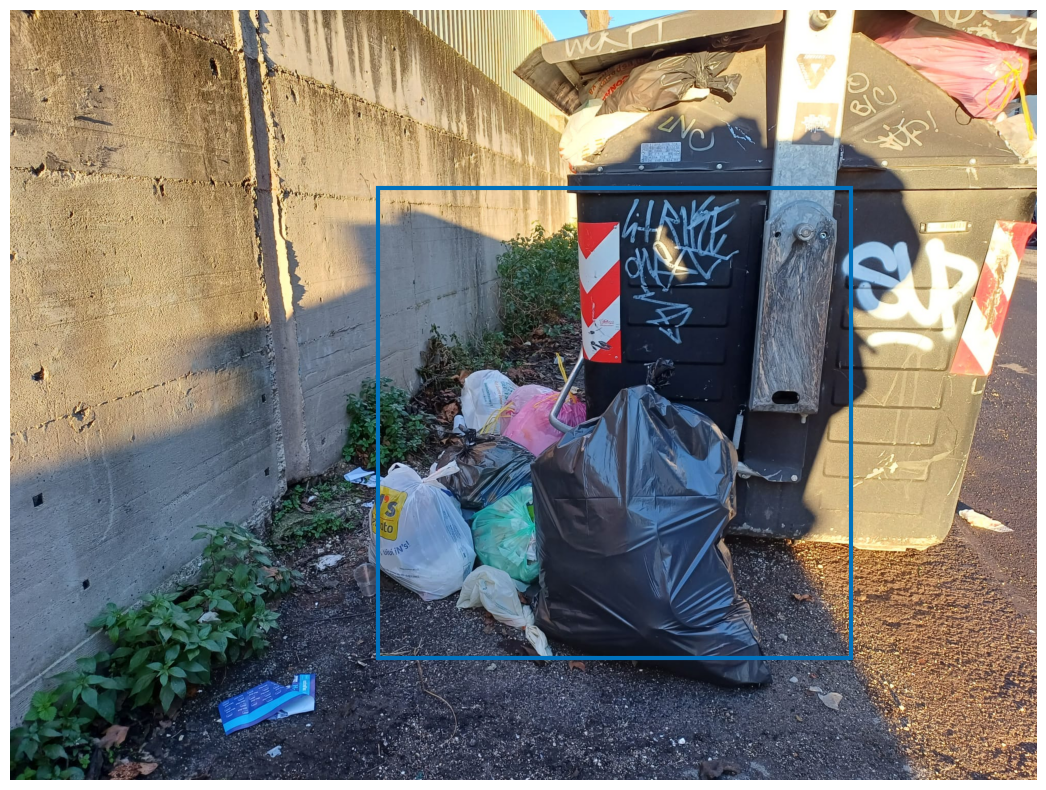

In [198]:
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('data/valid', image['file_name']))

# postprocess model outputs
width, height = img.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.3)
results = postprocessed_outputs[0]
plot_results(img, results['scores'], results['labels'], results['boxes'])